In [ ]:
import numpy as np

from scipy.stats import uniform, randint

#from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, balanced_accuracy_score, roc_auc_score, make_scorer, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb
import pandas as pd

In [ ]:
df = pd.read_csv('Telco.csv')

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Cust ID doesn't really do anything for us. We don't want to predict anything off of the ID that we assign them.
df.drop(['customerID'],
        axis = 1, inplace = True)

In [ ]:
#Lets save the names of all the columns in names for now
names = list(df)
print(names)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [ ]:
#Getting rid of white space helps with printing out the final tree so that we can see the effects nicely. In reality, this isn't important if all you are doing is predicting.
#I also don't want the senior citezens to be denoted by 0 or 1. This is for the one hot encoding later.
df['SeniorCitizen'].replace(0, 'False', regex = True, inplace = True)
df['SeniorCitizen'].replace(1, 'True', regex = True, inplace = True)
df.replace(' ', '_', regex = True, inplace = True)
print(df['InternetService'].unique(),
      df['SeniorCitizen'].unique())

array(['DSL', 'Fiber_optic', 'No'], dtype=object)

In [ ]:
#Let's check to see if there any NaNs and what types of data we are working with
print("Sum of NaNs: {}\n\nTypes:\n{}".format(df.isnull().values.sum(), df.dtypes))

Sum of NaNs: 0

Types:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [ ]:
#Let's make sure that the data in the columns is what we would expect.
for name in names:
  print(name, df[name].unique())

gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService ['No' 'Yes']
MultipleLines ['No_phone_service' 'No' 'Yes']
InternetService ['DSL' 'Fiber_optic' 'No']
OnlineSecurity ['No' 'Yes' 'No_internet_service']
OnlineBackup ['Yes' 'No' 'No_internet_service']
DeviceProtection ['No' 'Yes' 'No_internet_service']
TechSupport ['No' 'Yes' 'No_internet_service']
StreamingTV ['No' 'Yes' 'No_internet_service']
StreamingMovies ['No' 'Yes' 'No_internet_service']
Contract ['Month-to-month' 'One_year' 'Two_year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic_check' 'Mailed_check' 'Bank_transfer_(automatic)'
 'Credit_card_(automatic)']
MonthlyCharges [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges ['29.85' '1889

In [ ]:
#Notice that TotalCharges are actually an object type instead of a numeric. We should try to change it to numeric.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
#ValueError: Unable to parse string "_" at position 488

ValueError: ignored

In [ ]:
#Let's try finding the number of rows that don't have a value in them
len(df.loc[df['TotalCharges'] == '_']) 
#Since there are only 11 of them, we are going to just set these to 0.

11

In [ ]:
#Set the values to 0
df.loc[(df['TotalCharges'] == '_'), 'TotalCharges'] = 0

In [ ]:
#Running it again, notice that we are good to go! 'TotalCharges' are now a numeric column
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['TotalCharges'].dtypes

dtype('float64')

In [ ]:
target = df['Churn'].copy()
features = df.drop('Churn', axis = 1).copy()

One-Hot Encoding

In [ ]:
#Notice that we have a lot of categorical data. We need to change these to get something XGBoost can work with.
#This trick is called "One-Hot Encoding"
features.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [ ]:
target_names = list(target)
feature_names = list(features)

In [ ]:
#Notice that this will change gender into two other columns (based off how many unique responses there were) so that we can tell what is going on.
pd.get_dummies(features, columns = ['gender']).head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender_Female,gender_Male
0,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,1,0
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,0,1
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,0,1
3,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,0,1
4,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1,0


In [ ]:
#Lets go ahead and encode all these and then put the new df into "features_encoded"
features_encoded = pd.get_dummies(features, columns = ['PaymentMethod', 'gender', 'SeniorCitizen',
                                                       'Partner', 'Dependents', 'PhoneService',
                                                       'MultipleLines', 'InternetService', 'OnlineSecurity',
                                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                                       'StreamingTV', 'StreamingMovies', 'Contract', 
                                                       'PaperlessBilling'])
features_encoded.head()

,tenure,MonthlyCharges,TotalCharges,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check,gender_Female,gender_Male,SeniorCitizen_False,...,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes
0,1,29.85,29.85,0,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,0,1
1,34,56.95,1889.50,0,0,0,1,0,1,1,...,0,0,1,0,0,0,1,0,1,0
2,2,53.85,108.15,0,0,0,1,0,1,1,...,0,0,1,0,0,1,0,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,1,0
4,2,70.70,151.65,0,0,1,0,1,0,1,...,0,0,1,0,0,1,0,0,0,1


In [ ]:
#One last thing, lets make sure that everything in the target is as we would expect.
target.unique() #Good thing we did, because we actually want 1 and 0 in this column.

array(['No', 'Yes'], dtype=object)

In [ ]:
#That's better. Notice I set 'No' to 0 and 'Yes' to 1.
target.replace('No', 0, regex = True, inplace = True)
target.replace('Yes', 1, regex = True, inplace = True)
target = pd.to_numeric(target)
target.unique()

array([0, 1])

Let's work on actually building the model (finally)

In [ ]:
#Here, we are calculating the percent of people that left the company
sum(target)/len(target) #It's about close to 27.

0.2653698707936959

In [ ]:
#The reason that we did the previous line is so that we can know that we need to stratify the train/test data for the target. 
#This is stratifing the split since we know that the data is not fairly split. If our ratio was closer to 0.5, then we wouldn't need to stratify anything.
feat_train, feat_test, targ_train, targ_test = train_test_split(features_encoded, target, stratify = target)

In [ ]:
#Here we actually set up the model. I'm doing early stopping. This means that if we build 10 trees and the prediction doesn't really emprove we stop the algorithm.
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', missing = None)
clf_xgb.fit(feat_train,
            targ_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(feat_test, targ_test)])

[0]	validation_0-aucpr:0.553679
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.564631
[2]	validation_0-aucpr:0.589315
[3]	validation_0-aucpr:0.58827
[4]	validation_0-aucpr:0.588358
[5]	validation_0-aucpr:0.58812
[6]	validation_0-aucpr:0.611733
[7]	validation_0-aucpr:0.618247
[8]	validation_0-aucpr:0.621741
[9]	validation_0-aucpr:0.619069
[10]	validation_0-aucpr:0.619084
[11]	validation_0-aucpr:0.620263
[12]	validation_0-aucpr:0.623069
[13]	validation_0-aucpr:0.626566
[14]	validation_0-aucpr:0.626934
[15]	validation_0-aucpr:0.627611
[16]	validation_0-aucpr:0.626427
[17]	validation_0-aucpr:0.630176
[18]	validation_0-aucpr:0.630259
[19]	validation_0-aucpr:0.631457
[20]	validation_0-aucpr:0.632761
[21]	validation_0-aucpr:0.634869
[22]	validation_0-aucpr:0.635023
[23]	validation_0-aucpr:0.638497
[24]	validation_0-aucpr:0.638422
[25]	validation_0-aucpr:0.639505
[26]	validation_0-aucpr:0.642882
[27]	validation_0-aucpr:0.643328
[28]	validation_0-aucp

XGBClassifier()

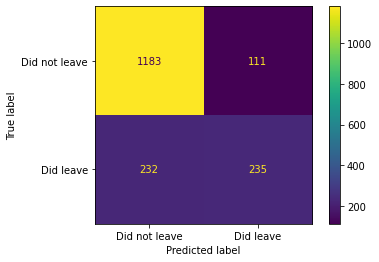

In [ ]:
#Let's make a confusion matrix to see what it's getting wrong.
plot_confusion_matrix(clf_xgb,
                      feat_test,
                      targ_test,
                      values_format = 'd',
                      display_labels = ["Did not leave", "Did leave"])
#Notice that this model is accuractly predicting people that did not leave. The problem is, we are mainly interested in the people that did leave, since they are the ones that cost the most money.
#In this case, we can see that XGBoost did not do a very good job (right around random guess) when it comes to the classification that we are interested in.
#I think a big reason that this is happening is because we have wildly imbalanced data.

Let's fix these problems by fine tuning the hyper parameters.

In [ ]:
## ROUND 1 ##
#param_grid = {
#    'max_depth': [3,4,5],
#    'learning_rate': [0.1, 0.01, 0.05],
#    'gamma': [0, 0.25, 1.0],
#    'reg_lambda': [0, 1.0, 10.0],
#    'scale_pos_weight': [1, 3, 5]
#}
#Here's the output: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}
#Since it looks like nothing is in the middle, I am going to try to move everything over and try again

param_grid = {
    'max_depth': [1, 2, 3],
    'learn_rate': [0.1, 0.2, 0.5],
    'gamma': [0.25, 1.5, 2.0],
    'reg_lambda': [10, 11, 12],
    'scale_pos_weight': [1, 2, 3]
}
#Here's the output: {'gamma': 1.0, 'learning_rate': 0.2, 'max_depth': 1, 'reg_lambda': 0, 'scale_pos_weight': 1}
#It looks like some of them have found a good value. I'll stick with those. The max_depth is weird, I'm not sure what is going on there.

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  subsample = 0.9, #This helps speed up everything. we only us 90% of the data per tree
                                  colsample_bytree = 0.5), #We are only selecting 50% of the columns. This helps with speed and overfitting.
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 0,
    n_jobs = 10,
    cv = 3)

optimal_params.fit(feat_train,
                   targ_train,
                   early_stopping_rounds = 10,
                   eval_metric = 'auc',
                   eval_set = [(feat_test, targ_test)],
                   verbose = False)
print(optimal_params.best_params_)

{'gamma': 2.0, 'learn_rate': 0.1, 'max_depth': 2, 'reg_lambda': 10, 'scale_pos_weight': 1}


Let's make the final call to the XGBoost

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            gamma = 0.25,
                            learn_rate = 0.1,
                            max_depth = 4,
                            reg_lambda = 10, 
                            scale_pos_weight = 3, 
                            subsample = 0.9,
                            colsample_bytree = 0.5)

clf_xgb.fit(feat_train,
            targ_train,
            verbose = True,
            early_stopping_rounds = 10,
            eval_metric = 'aucpr',
            eval_set = [(feat_test, targ_test)])

[0]	validation_0-aucpr:0.524941
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.590821
[2]	validation_0-aucpr:0.593517
[3]	validation_0-aucpr:0.590833
[4]	validation_0-aucpr:0.591041
[5]	validation_0-aucpr:0.613989
[6]	validation_0-aucpr:0.614191
[7]	validation_0-aucpr:0.614621
[8]	validation_0-aucpr:0.615242
[9]	validation_0-aucpr:0.622576
[10]	validation_0-aucpr:0.62561
[11]	validation_0-aucpr:0.628854
[12]	validation_0-aucpr:0.628802
[13]	validation_0-aucpr:0.629812
[14]	validation_0-aucpr:0.62822
[15]	validation_0-aucpr:0.631769
[16]	validation_0-aucpr:0.633312
[17]	validation_0-aucpr:0.638488
[18]	validation_0-aucpr:0.640431
[19]	validation_0-aucpr:0.642616
[20]	validation_0-aucpr:0.646399
[21]	validation_0-aucpr:0.64738
[22]	validation_0-aucpr:0.64702
[23]	validation_0-aucpr:0.645127
[24]	validation_0-aucpr:0.646897
[25]	validation_0-aucpr:0.64755
[26]	validation_0-aucpr:0.648044
[27]	validation_0-aucpr:0.64702
[28]	validation_0-aucpr:0.

XGBClassifier(colsample_bytree=0.5, gamma=0.25, lean_rate=0.1, max_depth=4,
              reg_lambda=10, scale_pos_weight=3, subsample=0.9)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


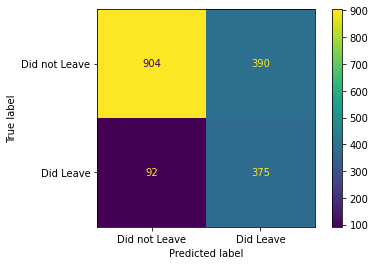

In [ ]:
plot_confusion_matrix(clf_xgb,
                      feat_test,
                      targ_test,
                      values_format = 'd',
                      display_labels = ["Did not Leave", "Did Leave"])
#One thing about the data: Notice that the accuracy has gone down (not by a ton) for the did not leave category. This means that we were predicting that less accuractly.
#However, notice that we did muc better on the did leave category.
#This means that we sacrificed the "did not leave" predictions for the "Did Leave" predictions.
#I decided this is better since we are likely more interested in predicting if someone is going to leave, rather than if they are going to stay.
#(if they leave, we loose money. If they stay, then nothing super different happens...)

weight:  {'Contract_Month-to-month': 1, 'OnlineSecurity_No': 2, 'TotalCharges': 6, 'PaymentMethod_Electronic_check': 3, 'Contract_Two_year': 1, 'TechSupport_No': 1}
gain:  {'Contract_Month-to-month': 1706.58386, 'OnlineSecurity_No': 172.0615234, 'TotalCharges': 18.466636023333333, 'PaymentMethod_Electronic_check': 13.974664066666667, 'Contract_Two_year': 20.1901016, 'TechSupport_No': 58.494751}
cover:  {'Contract_Month-to-month': 1811.25, 'OnlineSecurity_No': 905.625, 'TotalCharges': 291.75, 'PaymentMethod_Electronic_check': 266.3333333333333, 'Contract_Two_year': 186.75, 'TechSupport_No': 885.25}
total_gain:  {'Contract_Month-to-month': 1706.58386, 'OnlineSecurity_No': 344.1230468, 'TotalCharges': 110.79981614, 'PaymentMethod_Electronic_check': 41.9239922, 'Contract_Two_year': 20.1901016, 'TechSupport_No': 58.494751}
total_cover:  {'Contract_Month-to-month': 1811.25, 'OnlineSecurity_No': 1811.25, 'TotalCharges': 1750.5, 'PaymentMethod_Electronic_check': 799.0, 'Contract_Two_year': 186

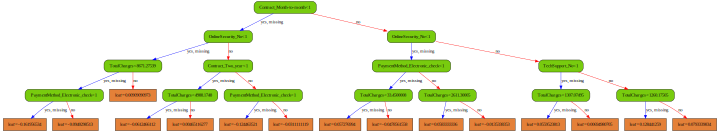

In [ ]:
#Let's draw the first tree so that we know a little bit about what is going on with the data.
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                            gamma = 0.25,
                            lean_rate = 0.1,
                            max_depth = 4,
                            reg_lambda = 10, 
                            scale_pos_weight = 3, 
                            subsample = 0.9,
                            colsample_bytree = 0.5,
                            n_estimators = 1)
clf_xgb.fit(feat_train, targ_train)

bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
  print('%s: ' % importance_type, bst.get_score(importance_type = importance_type))

node_params = {'shape': 'box',
                 'style': 'filled, rounded',
                 'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_trees = 0, size = '10,10',
                condition_node_params = node_params,
                leaf_node_params = leaf_params)